# Comments
<font color="red">
After doing some initial EDA, it seems like we should try perform a prediction like this:

Will a train delay or not? 

If Min_Delay > 0 , target = 1 (Yes) 

If Min_Delay <= 1, target = 0 (No)

That is probably not a linear regression question, we can try to answer that question in logistic regression
</font>


#Objective
The object of this effort is to analyze the delays in toronto_subway_data and find what questions can be answered from this data.

### Set up authentication for google. This is required to pull data from bigquery

In [2]:
from google.colab import auth
auth.authenticate_user()

###Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from google.colab import auth
auth.authenticate_user()


###Pull the dataframe from bigquery

In [2]:
#Please change the query to pull appropriate data
%%bigquery  df --project ml-notebooks-324808 --verbose
select *
from `toronto_subway.toronto_subway_delays`


Executing query with job ID: e4234cc2-cbe5-4218-a764-ecaa612b362a
Query executing: 0.57s
Query complete after 0.96s


#Exploratory data analysis


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143917 entries, 0 to 143916
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Date       143917 non-null  object
 1   Time       143917 non-null  object
 2   Day        143917 non-null  object
 3   Station    143917 non-null  object
 4   Code       143916 non-null  object
 5   Min_Delay  143917 non-null  int64 
 6   Min_Gap    143917 non-null  int64 
 7   Bound      111703 non-null  object
 8   Line       143373 non-null  object
 9   Vehicle    143917 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 11.0+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Min_Delay,143917.0,2.197802,8.833085,0.0,0.0,0.0,3.0,999.0
Min_Gap,143917.0,3.254668,9.117866,0.0,0.0,0.0,6.0,999.0
Vehicle,143917.0,3938.319663,2447.175793,0.0,0.0,5211.0,5596.0,72537.0


In [3]:
#Lets copy the data first
data = df.copy()
data = data.drop(['Vehicle'], axis=1)

### Data Cleanup

In [10]:
#lets value count to see how many values we have for delays
data.isnull().sum()
data = data.dropna(axis=0)
data.isnull().sum()

Date         0
Time         0
Day          0
Station      0
Code         0
Min_Delay    0
Min_Gap      0
Bound        0
Line         0
dtype: int64

# Query? 

##Can we predict Min_Delay > 0 with given labels?

In [15]:
delays = data[data.Min_Delay>0]

##Target distribution ( Is it normal?)


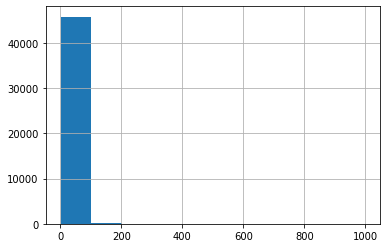

In [17]:
#Check graphically
delays.Min_Delay.hist()

As obvious from the above histogram, we have some very large outliers. Lets remove those first

### Remove outliers

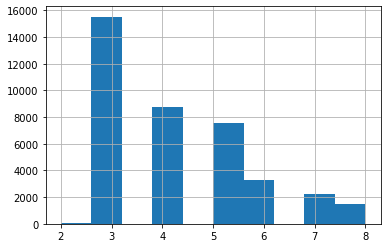

In [40]:
q25,q50,q75 = np.percentile(delays.Min_Delay, [25,50,75])
iqr = q75-q25
max = q75 + 1.5 * (iqr)
min = q25 - 1.5 * (iqr)

delays = delays[delays.Min_Delay >= min]
delays = delays[delays.Min_Delay <= max]

#draw histogram again
delays.Min_Delay.hist()

In [41]:
from scipy.stats.mstats import normaltest
#Check with stats
normaltest(delays.Min_Delay.values)

NormaltestResult(statistic=4500.861362867484, pvalue=0.0)

In [42]:
delays.skew()

Min_Delay    0.982220
Min_Gap     -0.086362
dtype: float64

### Lets apply log to see if right skewness is removed


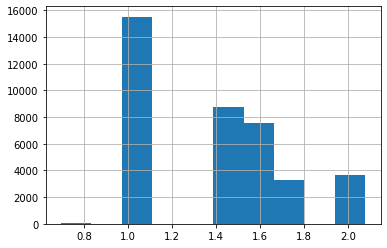

In [43]:
delays_log = np.log(delays.Min_Delay)
delays_log.hist()

###Try square root

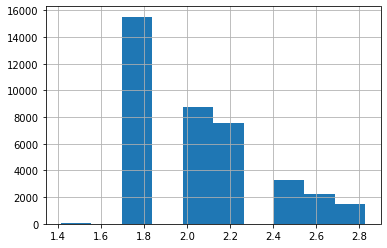

In [44]:
delays_sq = np.sqrt(delays.Min_Delay)
delays_sq.hist()

### Try boxcox

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


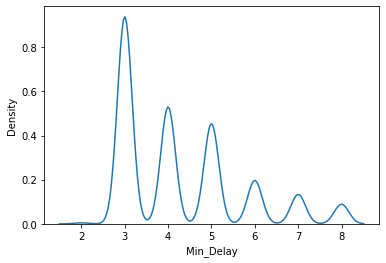

In [53]:
from scipy.stats import boxcox
delays_boxcox = boxcox(delays.Min_Delay)
boxcox_MinDelay = delays_boxcox[0]
lam = delays_boxcox[1]


sns.distplot(delays.Min_Delay, hist=False, kde=True) 

In [46]:
normaltest(delays.Min_Delay)

NormaltestResult(statistic=4500.861362867484, pvalue=0.0)